# Step 0 : Leiden Clustering in Mesenchyme

In [1]:
# Import relevant modules
import pandas as pd
import numpy as np
import scanpy as sc
import louvain
import igraph
import re
import os
import sys
import json
import gc

In [5]:
%config InlineBackend.figure_format = 'retina'  # For high-resolution displays
%config InlineBackend.print_figure_kwargs = {'dpi': 100}  # Set DPI

In [2]:
adata=sc.read("../../processed_data/integrated_data/20241024_mesenchyme.h5ad")

Since we subset mesenchyme from full anndata, so we rerun the `sc.pp.neighbors` for better clusterring.

In [3]:
sc.pp.neighbors(adata,use_rep="X_SCANVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

2024-10-25 12:59:17.501921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 12:59:19.354310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_309558/140703081.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


We gradually increased the resolution to get cluster number from 1 to 100. When cluster number increasing, the boundary between clusters may be vague. So we set 100 as the maximal number.

In [23]:
json_file = open("config/mesenchyme_parameter.json")
# read json into dictionary
json_str = json_file.read()
parameter_dict = json.loads(json_str)

global_seed = parameter_dict["global_seed"]
target_clusterN = parameter_dict["target_clusterN"]
start_res = parameter_dict["start_res"]
end_res = parameter_dict["end_res"]
step_size = parameter_dict["step_size"]
include_low_res = parameter_dict["include_low_res"]
n_neighbors = parameter_dict["k_param"]
min_cells_valid = parameter_dict["min_cells_valid"]
additional_clustering_suffix = parameter_dict["additional_clustering_suffix"]

#define resolution range, hardcoded atm
resolutions = [round(x*step_size,3) for x in range(int(1/step_size)*start_res,int(1/step_size)*end_res+1)]
if(include_low_res):
  low_res_list = [0.001,0.005,0.01,0.05,0.1,0.175,0.25,0.5,0.75]
  #low_res_list = [0.001,0.005,0.0075,0.01,0.05,0.1,0.175,0.25,0.5,0.75,3,5,6,7,15,16,28,37,38,45,50]
  resolutions = low_res_list + resolutions


In [25]:
for res in resolutions:
        key_name = "leiden_clusters_"+str(res)
        sc.tl.leiden(adata,resolution=res,key_added=key_name,random_state=global_seed,neighbors_key='neighbors') # could use neighbors_key
        value_counts = adata.obs[key_name].value_counts()
        print(" Ran leiden with resolution "+str(res)+" and found "+str(len(set(adata.obs[key_name])))+" total clusters with "+str(len(value_counts[value_counts > min_cells_valid]))+" valid clusters")
        if(len(value_counts[value_counts > min_cells_valid]) >= target_clusterN):
            print(" Reached "+str(len(value_counts[value_counts > min_cells_valid]))+" valid clusters")
            break    


 Ran leiden with resolution 0.001 and found 1 total clusters with 1 valid clusters
 Ran leiden with resolution 0.005 and found 1 total clusters with 1 valid clusters
 Ran leiden with resolution 0.01 and found 1 total clusters with 1 valid clusters
 Ran leiden with resolution 0.05 and found 4 total clusters with 4 valid clusters
 Ran leiden with resolution 0.1 and found 7 total clusters with 6 valid clusters
 Ran leiden with resolution 0.175 and found 12 total clusters with 10 valid clusters
 Ran leiden with resolution 0.25 and found 14 total clusters with 12 valid clusters
 Ran leiden with resolution 0.5 and found 20 total clusters with 19 valid clusters
 Ran leiden with resolution 0.75 and found 23 total clusters with 23 valid clusters
 Ran leiden with resolution 1 and found 30 total clusters with 29 valid clusters
 Ran leiden with resolution 2 and found 52 total clusters with 52 valid clusters
 Ran leiden with resolution 3 and found 67 total clusters with 67 valid clusters
 Ran leide

In [26]:
adata

AnnData object with n_obs × n_vars = 166863 × 36303
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth position', 'Histology', 'Sex', 'Gene Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related assay', 'Journal', 'Data Source', 'Data location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'leiden_clusters_0.001', 'leiden_clusters_0.005', 'leiden_clusters_0.01', 'leiden_clusters_0.05', 'leiden_clusters_0.1', 'leiden_clusters_0.175', 'leiden_clusters_0.25', 'leiden_clusters_0.

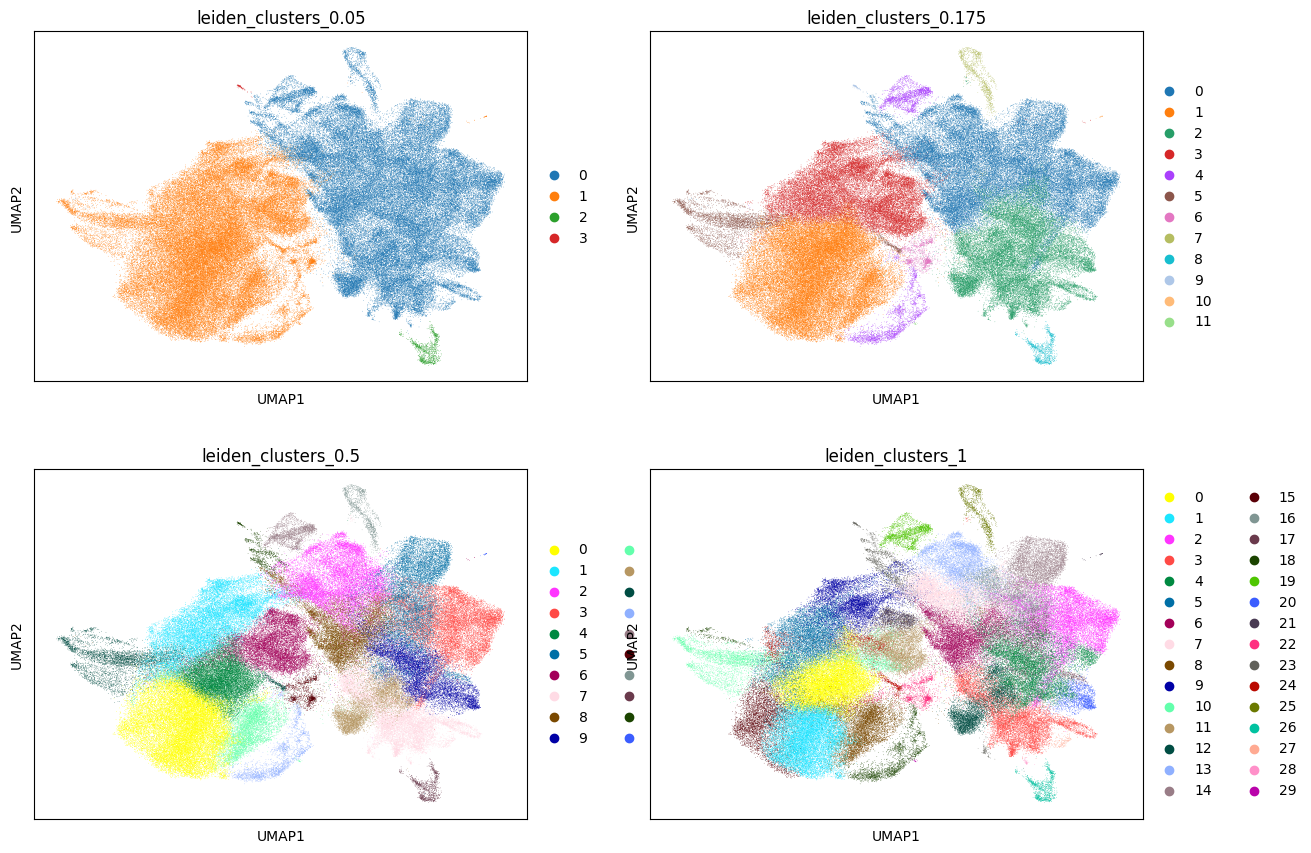

In [31]:
sc.pl.umap(adata, color=['leiden_clusters_0.05','leiden_clusters_0.175',  'leiden_clusters_0.5', 
                         'leiden_clusters_1'],ncols=2)

In [28]:
meta_subset = adata.obs.filter(regex=("leiden_clusters_"))
meta_subset.to_csv("../../processed_data/metadata/20241025_mes_leiden_metadata.csv")

In [29]:
adata.write_h5ad("../../processed_data/integrated_data/20241024_mesenchyme.h5ad")